<a href="https://colab.research.google.com/github/alecbidaran/Pytorch_excersies/blob/main/pix2pix.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
if not os.path.exists('ShoeV2_photo'):
    !wget https://www.dropbox.com/s/g6b6gtvmdu0h77x/ShoeV2_photo.zip
    !unzip -q ShoeV2_photo.zip


--2021-07-07 07:08:39--  https://www.dropbox.com/s/g6b6gtvmdu0h77x/ShoeV2_photo.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:6016:18::a27d:112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/g6b6gtvmdu0h77x/ShoeV2_photo.zip [following]
--2021-07-07 07:08:40--  https://www.dropbox.com/s/raw/g6b6gtvmdu0h77x/ShoeV2_photo.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucea23ced8da60e7e76a07136902.dl.dropboxusercontent.com/cd/0/inline/BR0PI1Ud-mK8YsGPo7w8_cvuInlPyP3h27BDvJelPX2cDxUD9b5KVj5bsKhk_KMnlwguOM-HjPE6fNV8TY41yaR6_9MansTWzvGR3MXCuGwp783N17xvEZ5prwuiDVqh3fbv5BnaI74BAcQYw9tsQd1Z/file# [following]
--2021-07-07 07:08:40--  https://ucea23ced8da60e7e76a07136902.dl.dropboxusercontent.com/cd/0/inline/BR0PI1Ud-mK8YsGPo7w8_cvuInlPyP3h27BDvJelPX2cDxUD9b5KVj5bsKhk_KMnlwguOM-HjPE6fN

In [ ]:
!pip install -U torch_snippets
from torch_snippets import *
device = 'cuda' if torch.cuda.is_available() else 'cpu'

Requirement already up-to-date: torch_snippets in /usr/local/lib/python3.7/dist-packages (0.426)


2021-07-07 08:42:10.024 | WARNING  | torch_snippets.torch_loader:<module>:233 - Not importing Lightning Report
2021-07-07 08:42:10.352 | WARNING  | torch_snippets:<module>:13 - sklearn is not found. Skipping relevant imports from submodule `sklegos`
Exception: No module named 'sklego'


In [ ]:
import torch 
import numpy as np 
import cv2 
import matplotlib.pyplot as plt
torch.cuda.empty_cache()
from torchvision import transforms as T

In [ ]:
def detect_edge(img):
  img=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
  img=cv2.bilateralFilter(img,5,50,50)
  img=cv2.Canny(img,45,100)
  img=cv2.bitwise_not(img)
  img=cv2.cvtColor(img,cv2.COLOR_GRAY2RGB)
  return img


In [ ]:
def detect_edges(img):
    img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    img_gray = cv2.bilateralFilter(img_gray, 5, 50, 50)
    img_gray_edges = cv2.Canny(img_gray, 45, 100)
    img_gray_edges = cv2.bitwise_not(img_gray_edges) # invert black/white
    img_edges = cv2.cvtColor(img_gray_edges, cv2.COLOR_GRAY2RGB)
    return img_edges

IMAGE_SIZE = 256

preprocess = T.Compose([
    T.Lambda(lambda x: torch.Tensor(x.copy()).permute(2, 0, 1).to(device))
])

normalize = lambda x: (x - 127.5)/127.5

class ShoesData(torch.utils.data.Dataset):
    def __init__(self, items):
        self.items = items
    def __len__(self): return len(self.items)
    def __getitem__(self, ix):
        f = self.items[ix]
        try: im = read(f, 1)
        except:
            blank = preprocess(Blank(IMAGE_SIZE, IMAGE_SIZE, 3))
            return blank, blank
        edges = detect_edges(im)
        im, edges = resize(im, IMAGE_SIZE), resize(edges, IMAGE_SIZE)
        im, edges = normalize(im), normalize(edges)
        #self._draw_color_circles_on_src_img(edges, im)
        im, edges = preprocess(im), preprocess(edges)
        return edges, im

    def _draw_color_circles_on_src_img(self, img_src, img_target):
        non_white_coords = self._get_non_white_coordinates(img_target)
        for center_y, center_x in non_white_coords:
            self._draw_color_circle_on_src_img(img_src, img_target, center_y, center_x)

    def _get_non_white_coordinates(self, img):
        non_white_mask = np.sum(img, axis=-1) < 2.75
        non_white_y, non_white_x = np.nonzero(non_white_mask)
        # randomly sample non-white coordinates
        n_non_white = len(non_white_y)
        n_color_points = min(n_non_white, 300)
        idxs = np.random.choice(n_non_white, n_color_points, replace=False)
        non_white_coords = list(zip(non_white_y[idxs], non_white_x[idxs]))
        return non_white_coords

    def _draw_color_circle_on_src_img(self, img_src, img_target, center_y, center_x):
        assert img_src.shape == img_target.shape, "Image source and target must have same shape."
        y0, y1, x0, x1 = self._get_color_point_bbox_coords(center_y, center_x)
        color = np.mean(img_target[y0:y1, x0:x1], axis=(0, 1))
        img_src[y0:y1, x0:x1] = color

    def _get_color_point_bbox_coords(self, center_y, center_x):
        radius = 2
        y0 = max(0, center_y-radius+1)
        y1 = min(IMAGE_SIZE, center_y+radius)
        x0 = max(0, center_x-radius+1)
        x1 = min(IMAGE_SIZE, center_x+radius)
        return y0, y1, x0, x1

    def choose(self): return self[randint(len(self))]

In [ ]:
import glob 
from sklearn.model_selection import train_test_split

In [ ]:
train_idx,test_idxs=train_test_split(glob.glob("ShoeV2_photo/*"),test_size=0.2,random_state=10)
train_load=torch.utils.data.DataLoader(ShoesData(train_idx),batch_size=32,shuffle=True)
val_load=torch.utils.data.DataLoader(ShoesData(test_idxs),batch_size=32,shuffle=True)
inspect(*next(iter(train_load)))

Tensor	Shape: torch.Size([32, 3, 256, 256])	Min: -1.000	Max: 1.000	Mean: 0.914	dtype: torch.float32
Tensor	Shape: torch.Size([32, 3, 256, 256])	Min: -1.000	Max: 1.000	Mean: 0.629	dtype: torch.float32


In [ ]:
def init_weights(m):
  classname = m.__class__.__name__
  if classname.find("Conv")!=-1:
    torch.nn.init.normal_(m.weight.data,0.0,0.02)
  elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)
class UNetDown(torch.nn.Module):
    def __init__(self, in_size, out_size, normalize=True, dropout=0.0):
      super(UNetDown, self).__init__()
      layers=[torch.nn.Conv2d(in_size,out_size,4,2,padding=1,bias=False)]
      if normalize:
        layers.append(torch.nn.BatchNorm2d(out_size))
      layers.append(torch.nn.LeakyReLU())
      if dropout:
        layers.append(torch.nn.Dropout(dropout))
      self.model=torch.nn.Sequential(*layers)
    def forward(self,x):
      return self.model(x)
class UNetUp(torch.nn.Module):
    def __init__(self, in_size, out_size, dropout=0.0):
        super(UNetUp, self).__init__()
        layers=[
            torch.nn.ConvTranspose2d(in_size,out_size,4,2,padding=1,bias=False),
            torch.nn.InstanceNorm2d(out_size),
            torch.nn.ReLU(inplace=True)
        ]
        if dropout:
          layers.append(torch.nn.Dropout())
        self.model=torch.nn.Sequential(*layers)
    def forward(self,x,copy_x):
      model=self.model(x)
      fx=torch.cat((model,copy_x),1)
      return fx 


In [ ]:
class GeneratorUNet(torch.nn.Module):
    def __init__(self, in_channels=3, out_channels=3):
        super(GeneratorUNet, self).__init__()
        self.down1=UNetDown(in_channels,64,normalize=False)
        self.down2=UNetDown(64,128)
        self.down3=UNetDown(128,256)
        self.down4=UNetDown(256,512,dropout=0.5)
        self.down5=UNetDown(512,512,dropout=0.5)
        self.down6=UNetDown(512,512,dropout=0.5)
        self.down7=UNetDown(512,512,dropout=0.5)
        self.down8=UNetDown(512,512,normalize=False,dropout=0.5)
        self.up1=UNetUp(512,512,dropout=0.5)
        self.up2=UNetUp(1024,512,dropout=0.5)
        self.up3=UNetUp(1024,512,dropout=0.5)
        self.up4=UNetUp(1024,512,dropout=0.5)
        self.up5=UNetUp(1024,256,dropout=0.5)
        self.up6=UNetUp(512,128)
        self.up7=UNetUp(256,64)
        self.final=torch.nn.Sequential(torch.nn.Upsample(scale_factor=2),
                                       torch.nn.ZeroPad2d((1,0,0,1)),
                                       torch.nn.Conv2d(128,out_channels,4,padding=1),
                                       torch.nn.Tanh())
    def forward(self,x):
      d1=self.down1(x)
      d2=self.down2(d1)
      d3=self.down3(d2)
      d4=self.down4(d3)
      d5=self.down5(d4)
      d6=self.down6(d5)
      d7=self.down7(d6)
      d8=self.down8(d7)
      u1=self.up1(d8,d7)
      u2=self.up2(u1,d6)
      u3=self.up3(u2,d5)
      u4=self.up4(u3,d4)
      u5=self.up5(u4,d3)
      u6=self.up6(u5,d2)
      u7=self.up7(u6,d1)
      return self.final(u7)

class Discriminator(nn.Module):
    def __init__(self, in_channels=3):
        super(Discriminator, self).__init__()

        def discriminator_block(in_filters, out_filters, normalization=True):
            """Returns downsampling layers of each discriminator block"""
            layers = [nn.Conv2d(in_filters, out_filters, 4, stride=2, padding=1)]
            if normalization:
                layers.append(nn.InstanceNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *discriminator_block(in_channels * 2, 64, normalization=False),
            *discriminator_block(64, 128),
            *discriminator_block(128, 256),
            *discriminator_block(256, 512),
            nn.ZeroPad2d((1, 0, 1, 0)),
            nn.Conv2d(512, 1, 4, padding=1, bias=False)
        )

    def forward(self, img_A, img_B):
        img_input = torch.cat((img_A, img_B), 1)
        return self.model(img_input)

In [ ]:
from torchsummary import summary
generator = GeneratorUNet().to(device)
discriminator = Discriminator().to(device)

In [ ]:
def discriminator_train_step(real_src, real_trg, fake_trg):
    #discriminator.train()
    d_optimizer.zero_grad()

    prediction_real = discriminator(real_trg, real_src)
    error_real = criterion_GAN(prediction_real, torch.ones(len(real_src), 1, 16, 16).cuda())
    error_real.backward()

    prediction_fake = discriminator(fake_trg.detach(), real_src)
    error_fake = criterion_GAN(prediction_fake, torch.zeros(len(real_src), 1, 16, 16).cuda())
    error_fake.backward()

    d_optimizer.step()

    return error_real + error_fake

def generator_train_step(real_src, fake_trg):
    #discriminator.train()
    g_optimizer.zero_grad()
    prediction = discriminator(fake_trg, real_src)

    loss_GAN = criterion_GAN(prediction, torch.ones(len(real_src), 1, 16, 16).cuda())
    loss_pixel = criterion_pixelwise(fake_trg, real_trg)
    loss_G = loss_GAN + lambda_pixel * loss_pixel

    loss_G.backward()
    g_optimizer.step()
    return loss_G

denorm = T.Normalize((-1, -1, -1), (2, 2, 2))
def sample_prediction():
    """Saves a generated sample from the validation set"""
    data = next(iter(val_load))
    real_src, real_trg = data
    fake_trg = generator(real_src)
    img_sample = torch.cat([denorm(real_src[0]), denorm(fake_trg[0]), denorm(real_trg[0])], -1)
    img_sample = img_sample.detach().cpu().permute(1,2,0).numpy()
    show(img_sample, title='Source::Generated::GroundTruth', sz=12)

EPOCH: 1.000	errD: 1.045	errG: 20.476	(172.15s - 17042.77s remaining)


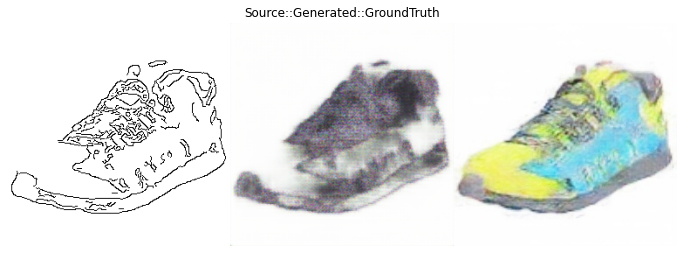

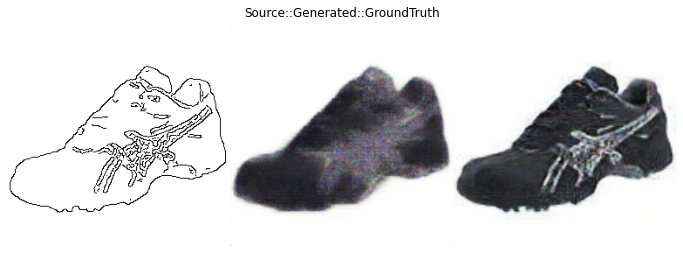

EPOCH: 2.000	errD: 0.529	errG: 10.665	(344.82s - 16895.95s remaining)


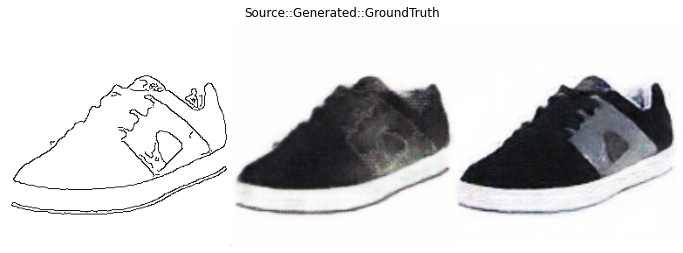

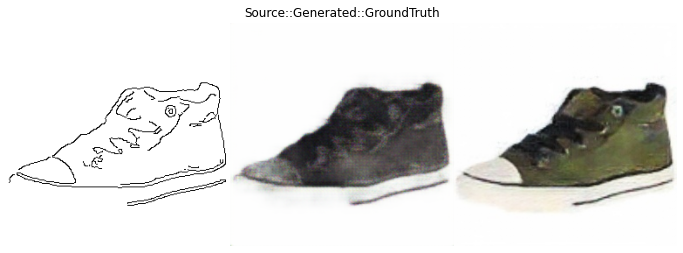

EPOCH: 3.000	errD: 0.528	errG: 9.017	(517.45s - 16730.79s remaining)


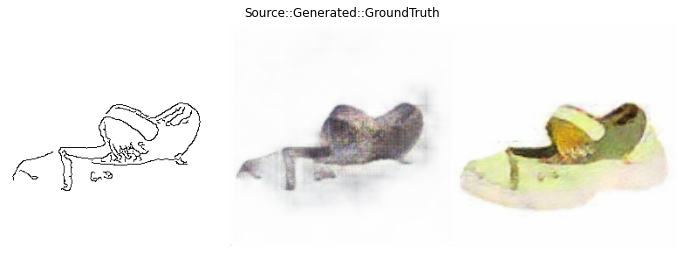

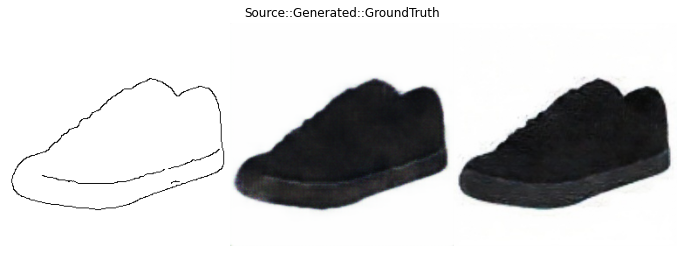

EPOCH: 4.000	errD: 0.474	errG: 8.356	(690.05s - 16561.14s remaining)


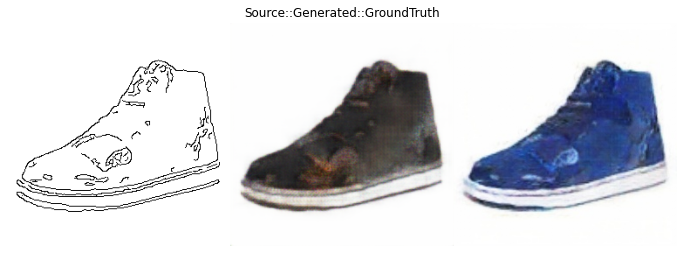

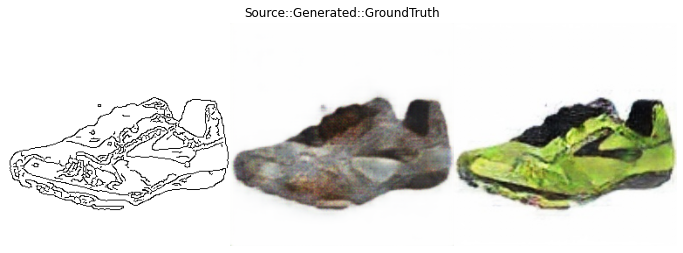

EPOCH: 5.000	errD: 0.405	errG: 7.902	(862.82s - 16393.59s remaining)


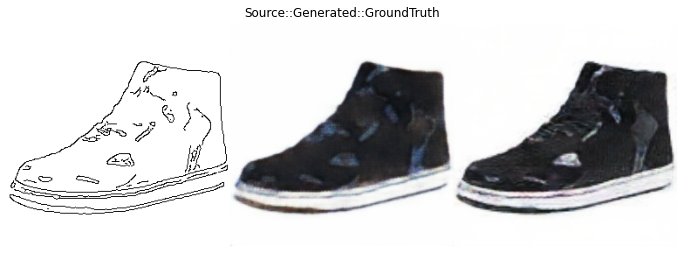

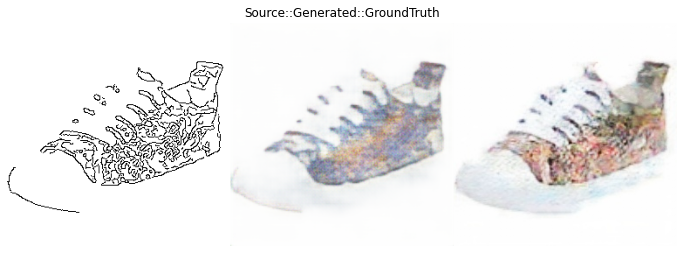

EPOCH: 6.000	errD: 0.411	errG: 7.587	(1035.57s - 16223.89s remaining)


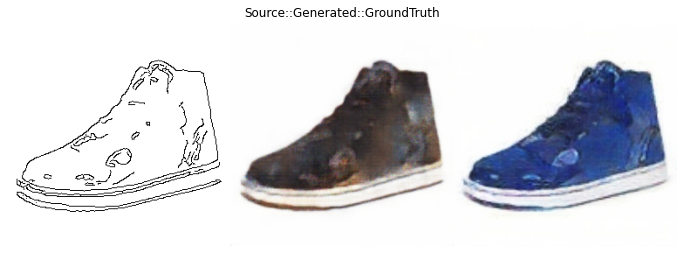

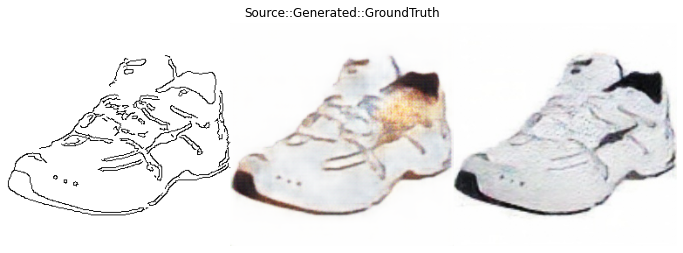

EPOCH: 7.000	errD: 0.389	errG: 7.305	(1208.37s - 16054.10s remaining)


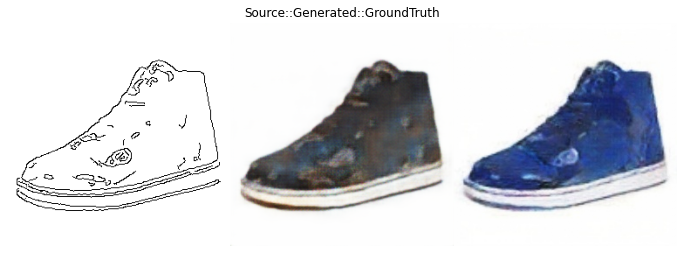

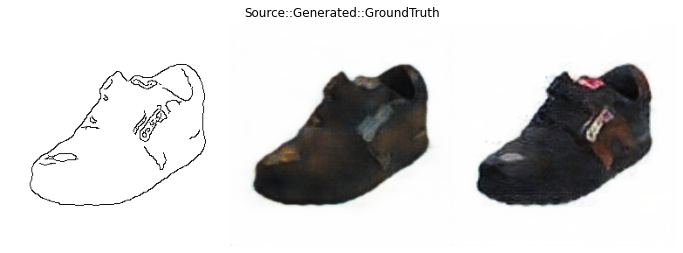

EPOCH: 8.000	errD: 0.391	errG: 7.050	(1381.10s - 15882.60s remaining)


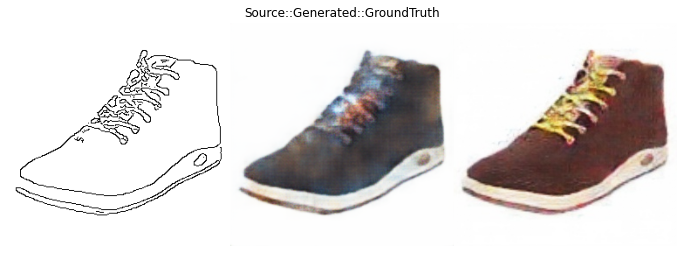

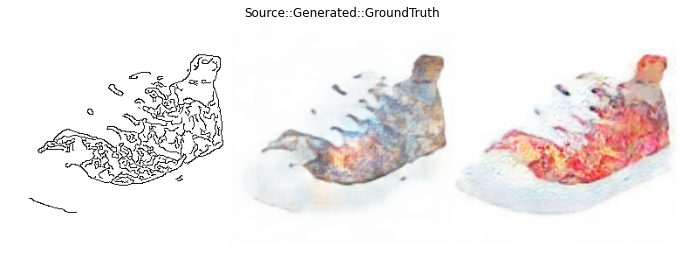

EPOCH: 9.000	errD: 0.400	errG: 6.811	(1553.83s - 15710.97s remaining)


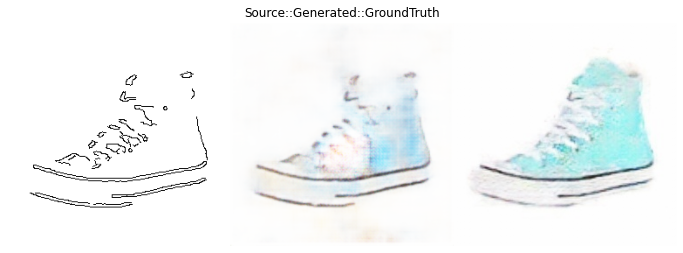

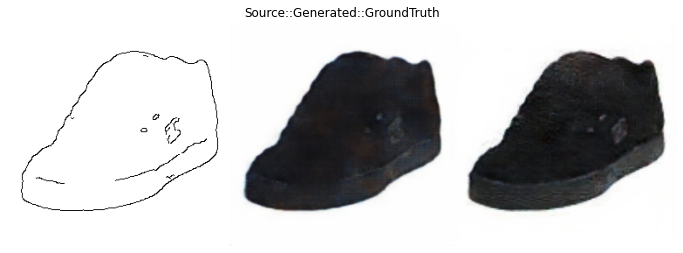

EPOCH: 10.000	errD: 0.410	errG: 6.509	(1726.46s - 15538.11s remaining)


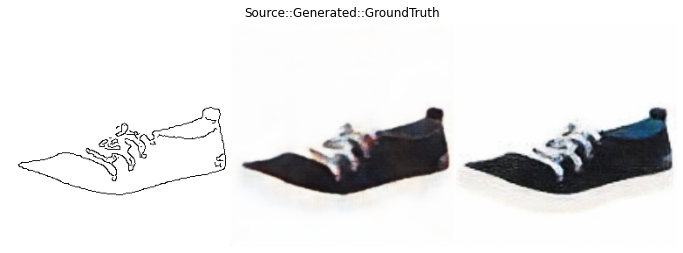

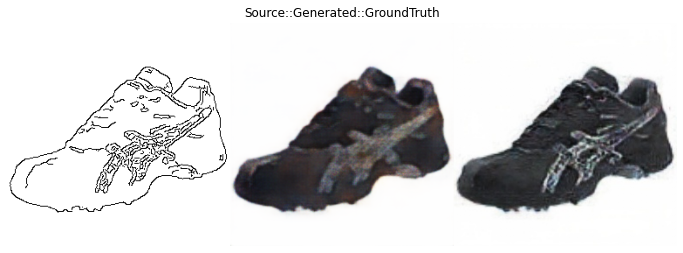

EPOCH: 11.000	errD: 0.436	errG: 6.213	(1899.10s - 15365.42s remaining)


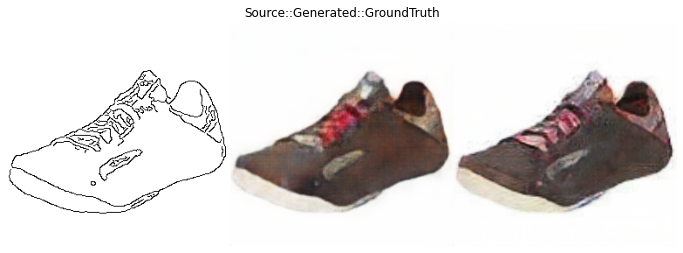

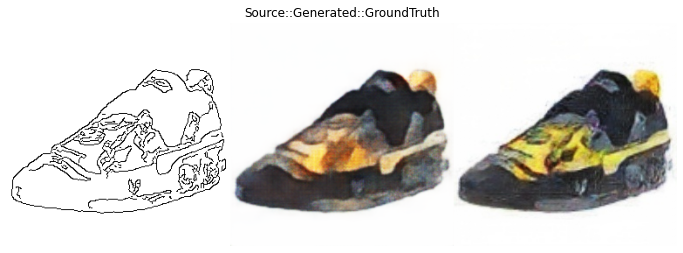

EPOCH: 12.000	errD: 0.420	errG: 5.960	(2071.65s - 15192.11s remaining)


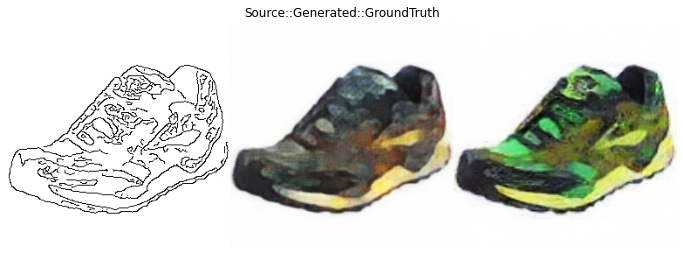

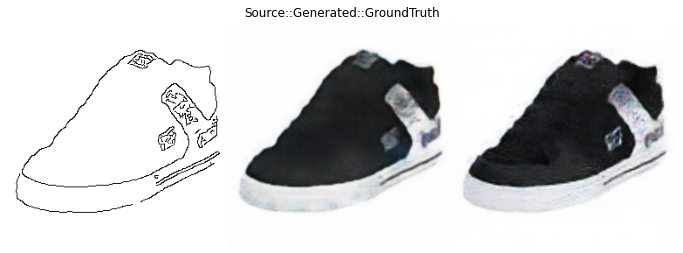

EPOCH: 13.000	errD: 0.431	errG: 5.725	(2244.29s - 15019.45s remaining)


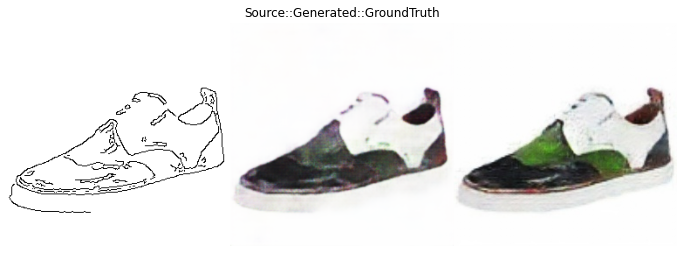

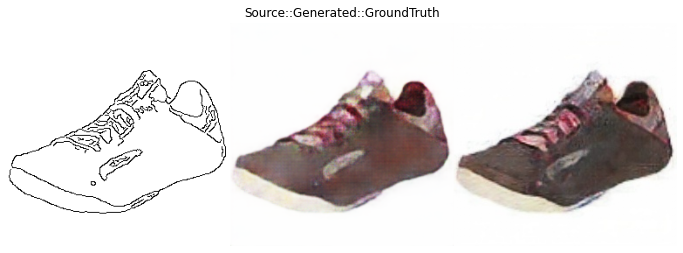

EPOCH: 14.000	errD: 0.445	errG: 5.525	(2416.91s - 14846.75s remaining)


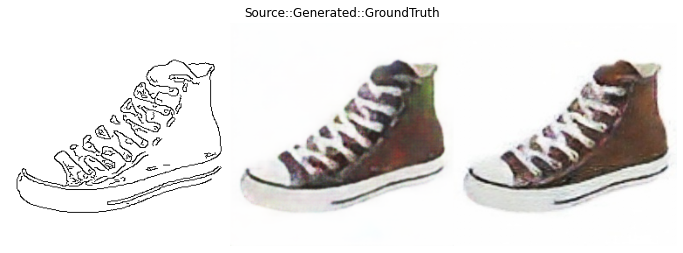

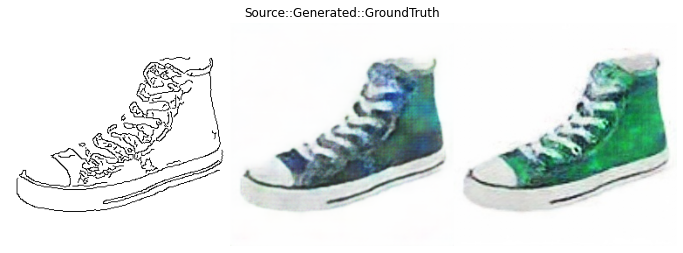

EPOCH: 15.000	errD: 0.443	errG: 5.311	(2589.52s - 14673.95s remaining)


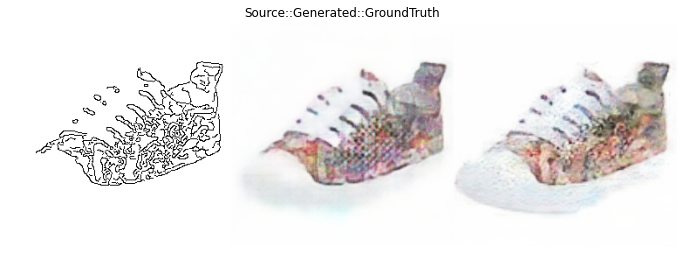

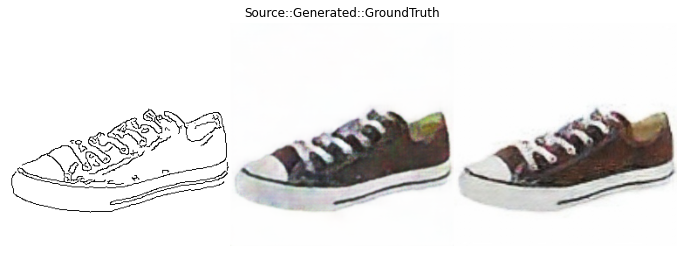

EPOCH: 15.282	errD: 0.400	errG: 5.545	(2639.24s - 14631.22s remaining)

KeyboardInterrupt: ignored

In [ ]:
generator=GeneratorUNet().to(device)
discriminator=Discriminator().to(device)
generator.apply(init_weights)
discriminator.apply(init_weights)
criterion_GAN=torch.nn.MSELoss()
criterion_pixelwise=torch.nn.L1Loss()
n_epochs=100
lambda_pixel = 100
g_optimizer = torch.optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))


epochs = 100
log = Report(epochs)
for epoch in range(epochs):
  N=len(train_load)
  for bx,batch in enumerate(train_load):
    train_src,real_trg=batch
    fake_target=generator(train_src)
    errD=discriminator_train_step(train_src,real_trg,fake_target)
    errG=generator_train_step(train_src,fake_target)
    log.record(pos=epoch+(1+bx)/N, errD=errD.item(), errG=errG.item(), end='\r')
  
  log.report_avgs(epoch+1)
  [sample_prediction() for _ in range(2)]